### **LEITURA E FORMATAÇÃO DO ARQUIVO**

In [20]:
import pandas as pd
from pyspark.sql.functions import *
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CSV_Reader").getOrCreate()
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import udf 
from pyspark.sql.types import StringType 


In [21]:
# Conexão JDBC ---


POSTGRES_JDBC_DRIVER_PATH = "C:\\spark\\spark-3.4.1\\jars\\postgresql-42.7.8.jar"


spark = SparkSession.builder \
    .appName("PostgreSQLConnection_Tech3") \
    .config("spark.jars", POSTGRES_JDBC_DRIVER_PATH) \
    .getOrCreate()

print("SparkSession iniciada e driver JDBC 'postgresql-42.7.8.jar' carregado com sucesso.")


print(f"Drivers carregados: {spark.sparkContext.getConf().get('spark.jars')}")

jdbc_url = "jdbc:postgresql://localhost:5432/Tech3" 
jdbc_user = "postgres" 
jdbc_password = "alef"
MODE = "overwrite" 

connection_properties = {
    "user": jdbc_user,
    "password": jdbc_password,

    "driver": "org.postgresql.Driver" 
}

print("Propriedades de conexão definidas.")

SparkSession iniciada e driver JDBC 'postgresql-42.7.8.jar' carregado com sucesso.
Drivers carregados: C:\spark\spark-3.4.1\jars\postgresql-42.7.8.jar
Propriedades de conexão definidas.


In [22]:
csv_path_julho = "PNAD_COVID_072020\PNAD_COVID_072020.csv"

df_julho = spark.read.csv(csv_path_julho, sep = ",", header=True, inferSchema=True)

In [23]:
csv_path_setembro = "PNAD_COVID_092020\PNAD_COVID_092020.csv"

df_setembro = spark.read.csv(csv_path_setembro, sep = ",", header=True, inferSchema=True)

In [24]:
csv_path_novembro = "PNAD_COVID_112020\PNAD_COVID_112020.csv"

df_novembro = spark.read.csv(csv_path_novembro, sep = ",", header=True, inferSchema=True)

In [25]:
# Seleciona apenas as colunas desejadas

colunas_desejadas = [
"A001","UPA","V1008","V1013","A002","A003","A006","B0015","B0011","B00111","B0012","B0014","B0018","B0019","B009F","B009D","B009B","B011","C001","C007C","C007E","C012","V1022","UF"]

df_novembro = df_novembro.select(colunas_desejadas)
df_setembro = df_setembro.select(colunas_desejadas)
df_julho = df_julho.select(colunas_desejadas)

In [26]:
#Junta os três meses em um unico DataFrame
df_completo = df_novembro.union(df_setembro).union(df_julho)



In [27]:

# Renomeia as colunas (exemplo: ajuste conforme necessário)
df_renamed = df_completo.withColumnRenamed("UF", "PESS_UF"
).withColumnRenamed("V1008", "CTRL_NUM_DOMICILIO"
).withColumnRenamed("V1013", "CTRL_MES"
).withColumnRenamed("V1022", "PESS_SIT_DOMICILIO"
).withColumnRenamed("UPA", "CTRL_UPA"
).withColumnRenamed("A001", "CTRL_NUM_MORADOR"
).withColumnRenamed("A002", "PESS_IDADE_MORADOR"
).withColumnRenamed("A003", "PESS_SEXO_MORADOR"
).withColumnRenamed("A006", "PESS_ESTUDA"
).withColumnRenamed("B0015", "SINT_DOR_CABECA"   
).withColumnRenamed("B0011", "SINT_FEBRE"
).withColumnRenamed("B0012", "SINT_TOSSE"
).withColumnRenamed("B0014", "SINT_DIF_RESPIRAR"
).withColumnRenamed("B0018", "SINT_CORIZA"
).withColumnRenamed("B0019", "SINT_FADIGA"
).withColumnRenamed("B00111", "SINT_PERDA_OLFATO"
).withColumnRenamed("B009F", "TESTE_SANGUE_VEIA"
).withColumnRenamed("B009D", "TESTE_SANGUE_DEDO"
).withColumnRenamed("B009B", "TESTE_SWAB"			   
).withColumnRenamed("B011", "DISTANC_SOCIAL"
).withColumnRenamed("C001", "TRAB_SP_TRABALHOU"
).withColumnRenamed("C007C", "TRAB_TIPO_TRABALHO"
).withColumnRenamed("C007E", "TRAB_QUANT_EMPREGADOS"
).withColumnRenamed("C012", "TRAB_PRESENCIAL"
                    )

df_renamed = df_renamed.withColumn(
    "CTRL_ID",
    concat(
        lpad(df_renamed["CTRL_UPA"], 15, "0"),
        lpad(df_renamed["CTRL_NUM_DOMICILIO"], 2, "0"),
        lpad(df_renamed["CTRL_NUM_MORADOR"], 2, "0")
    )
)


# Exibe o DataFrame renomeado
df_renamed.show()

+----------------+---------+------------------+--------+------------------+-----------------+-----------+---------------+----------+-----------------+----------+-----------------+-----------+-----------+-----------------+-----------------+----------+--------------+-----------------+------------------+---------------------+---------------+------------------+-------+-------------------+
|CTRL_NUM_MORADOR| CTRL_UPA|CTRL_NUM_DOMICILIO|CTRL_MES|PESS_IDADE_MORADOR|PESS_SEXO_MORADOR|PESS_ESTUDA|SINT_DOR_CABECA|SINT_FEBRE|SINT_PERDA_OLFATO|SINT_TOSSE|SINT_DIF_RESPIRAR|SINT_CORIZA|SINT_FADIGA|TESTE_SANGUE_VEIA|TESTE_SANGUE_DEDO|TESTE_SWAB|DISTANC_SOCIAL|TRAB_SP_TRABALHOU|TRAB_TIPO_TRABALHO|TRAB_QUANT_EMPREGADOS|TRAB_PRESENCIAL|PESS_SIT_DOMICILIO|PESS_UF|            CTRL_ID|
+----------------+---------+------------------+--------+------------------+-----------------+-----------+---------------+----------+-----------------+----------+-----------------+-----------+-----------+-----------------+---

### **DICIONÁRIOS DE DOMINIO DOS DADOS**

In [28]:
csv_path_dict = "Dicionario_PNAD_COVID_112020_20220621.csv"

# pula as 4 primeiras linhas e usa a 5ª como cabeçalho
df_dict = pd.read_csv(
    csv_path_dict, 
    sep=";", 
    encoding="latin1", 
    skiprows=4,   # pula as 4 primeiras
    header=0      # a próxima linha (linha 5) vira o cabeçalho
)

# Indices das linhas de comentários do dicionário 
indices_to_remove = [91, 169, 343, 569, 598, 614]

df_dict_filtered = df_dict.drop(indices_to_remove)

# Usar ffill para preencher os valores vazios com o valor anterior
df_dict_filtered['Ano'] = df_dict_filtered['Ano'].ffill()
df_dict_filtered['Ano de referência'] = df_dict_filtered['Ano de referência'].ffill()

# Criando DF spark
df_dict_filtered = spark.createDataFrame(df_dict_filtered)


#Ronomeando colunaaa
df_dict_rename = df_dict_filtered.withColumnRenamed("Ano", "COD_VAR"
).withColumnRenamed("Ano de referência", "DESCR_VAR"
).withColumnRenamed("Unnamed: 4", "COD_TIPO"
).withColumnRenamed("Unnamed: 5", "DESCR_TIPO")

df_dict_rename = df_dict_rename.select(
    "COD_VAR", "DESCR_VAR","COD_TIPO","DESCR_TIPO"
)

#FILTRANDO APENAS COLUNAS DESEJADAS
df_filtro = df_dict_rename.filter(col("COD_VAR").isin(colunas_desejadas))

df_filtro.show()


+-------+--------------------+--------+-------------------+
|COD_VAR|           DESCR_VAR|COD_TIPO|         DESCR_TIPO|
+-------+--------------------+--------+-------------------+
|     UF|Unidade da Federação|      11|           Rondônia|
|     UF|Unidade da Federação|      12|               Acre|
|     UF|Unidade da Federação|      13|           Amazonas|
|     UF|Unidade da Federação|      14|            Roraima|
|     UF|Unidade da Federação|      15|               Pará|
|     UF|Unidade da Federação|      16|              Amapá|
|     UF|Unidade da Federação|      17|          Tocantins|
|     UF|Unidade da Federação|      21|           Maranhão|
|     UF|Unidade da Federação|      22|              Piauí|
|     UF|Unidade da Federação|      23|              Ceará|
|     UF|Unidade da Federação|      24|Rio Grande do Norte|
|     UF|Unidade da Federação|      25|            Paraíba|
|     UF|Unidade da Federação|      26|         Pernambuco|
|     UF|Unidade da Federação|      27| 

In [29]:
dic_pess_uf_df = (
    df_filtro
    .filter(col("COD_VAR") == "UF")
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "PESS_UF")
    .withColumnRenamed("DESCR_TIPO", "PESS_UF_DESC"))



dic_pess_sit_domicilio_df = (
    df_filtro
    .filter(col("COD_VAR") == "V1022")
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "PESS_SIT_DOMICILIO")
    .withColumnRenamed("DESCR_TIPO", "PESS_SIT_DOMICILIO_DESC"))


dic_pess_sexo_morador = (
    df_filtro
    .filter(col("COD_VAR") == "A003")
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "PESS_SEXO_MORADOR")
    .withColumnRenamed("DESCR_TIPO", "PESS_SEXO_MORADOR_DESC"))



dic_sintomas_df = (
    df_filtro
    .filter(col("COD_VAR")=='B0012')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "SINT_COD")
    .withColumnRenamed("DESCR_TIPO", "SINT_DESC"))

dic_estuda_df = (
    df_filtro
    .filter(col("COD_VAR")=='A006')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "ESTUDA_COD")
    .withColumnRenamed("DESCR_TIPO", "ESTUDA_DESC"))    

dic_resultado_teste_df = (
    df_filtro
    .filter(col("COD_VAR")=='B009B')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "TESTE_COD")
    .withColumnRenamed("DESCR_TIPO", "TESTE_DESC"))    

dic_isolamento_social_df = (
    df_filtro
    .filter(col("COD_VAR")=='B011')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "ISO_COD")
    .withColumnRenamed("DESCR_TIPO", "ISO_DESC"))    

dic_trab_sp_trabalhou_df = (
    df_filtro
    .filter(col("COD_VAR")=='C001')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "TRAB_SP_TRABALHOU_COD")
    .withColumnRenamed("DESCR_TIPO", "TRAB_SP_TRABALHOU_DESC"))

dic_trab_tipo_trabalho_df = (
    df_filtro
    .filter(col("COD_VAR")=='C007C')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "TRAB_TIPO_TRABALHO_COD")
    .withColumnRenamed("DESCR_TIPO", "TRAB_TIPO_TRABALHO_DESC"))

dic_trab_qt_empregados_df = (
    df_filtro
    .filter(col("COD_VAR")=='C007E')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "TRAB_QUANT_EMPREGADOS_COD")
    .withColumnRenamed("DESCR_TIPO", "TRAB_QUANT_EMPREGADOS_DESC"))


dic_trab_ms_local_df = (
    df_filtro
    .filter(col("COD_VAR")=='C012')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "TRAB_MESMO_LOCAL_COD")
    .withColumnRenamed("DESCR_TIPO", "TRAB_MESMO_LOCAL_DESC"))



### **SEPARAÇÃO DOS DADOS NAS TABELAS DISTINTAS**

In [30]:
colunas_dados_pess = ["CTRL_MES", "CTRL_ID", "PESS_UF", "PESS_SIT_DOMICILIO", "PESS_IDADE_MORADOR", "PESS_SEXO_MORADOR","PESS_ESTUDA"]

df_dados_pess = df_renamed.select(colunas_dados_pess)

colunas_dados_trab = ["CTRL_MES", "CTRL_ID", "TRAB_SP_TRABALHOU", "TRAB_TIPO_TRABALHO", "TRAB_QUANT_EMPREGADOS", "TRAB_PRESENCIAL"]

df_dados_trab = df_renamed.select(colunas_dados_trab)

colunas_dados_sint = ["CTRL_MES", "CTRL_ID",  "SINT_FEBRE", "SINT_TOSSE", "SINT_DOR_CABECA", "SINT_DIF_RESPIRAR", "SINT_CORIZA", "SINT_FADIGA", "SINT_PERDA_OLFATO"]

df_dados_sint = df_renamed.select(colunas_dados_sint)

colunas_dados_iso_social = ["CTRL_MES", "CTRL_ID", "DISTANC_SOCIAL"]

df_dados_iso_social = df_renamed.select(colunas_dados_iso_social)


colunas_dados_tst_covd = ["CTRL_MES", "CTRL_ID","TESTE_SWAB", "TESTE_SANGUE_DEDO", "TESTE_SANGUE_VEIA"]

df_dados_dados_tst_covd = df_renamed.select(colunas_dados_tst_covd)


In [31]:
df_dados_pess.printSchema()
df_dados_trab.printSchema()
df_dados_sint.printSchema()
df_dados_iso_social.printSchema()
df_dados_dados_tst_covd.printSchema()


root
 |-- CTRL_MES: integer (nullable = true)
 |-- CTRL_ID: string (nullable = true)
 |-- PESS_UF: integer (nullable = true)
 |-- PESS_SIT_DOMICILIO: integer (nullable = true)
 |-- PESS_IDADE_MORADOR: integer (nullable = true)
 |-- PESS_SEXO_MORADOR: integer (nullable = true)
 |-- PESS_ESTUDA: integer (nullable = true)

root
 |-- CTRL_MES: integer (nullable = true)
 |-- CTRL_ID: string (nullable = true)
 |-- TRAB_SP_TRABALHOU: integer (nullable = true)
 |-- TRAB_TIPO_TRABALHO: integer (nullable = true)
 |-- TRAB_QUANT_EMPREGADOS: integer (nullable = true)
 |-- TRAB_PRESENCIAL: integer (nullable = true)

root
 |-- CTRL_MES: integer (nullable = true)
 |-- CTRL_ID: string (nullable = true)
 |-- SINT_FEBRE: integer (nullable = true)
 |-- SINT_TOSSE: integer (nullable = true)
 |-- SINT_DOR_CABECA: integer (nullable = true)
 |-- SINT_DIF_RESPIRAR: integer (nullable = true)
 |-- SINT_CORIZA: integer (nullable = true)
 |-- SINT_FADIGA: integer (nullable = true)
 |-- SINT_PERDA_OLFATO: integer 

In [32]:
# Tabela de Dados Pessoais
df_dados_pess.createOrReplaceTempView("dados_pessoais")

# Tabela de Dados de Trabalho
df_dados_trab.createOrReplaceTempView("dados_trabalho")

# Tabela de Dados de Sintomas
df_dados_sint.createOrReplaceTempView("dados_sintomas")

# Tabela de Dados de Isolamento Social
df_dados_iso_social.createOrReplaceTempView("dados_isolamento_social")

# Tabela de Dados de Teste COVID
df_dados_dados_tst_covd.createOrReplaceTempView("dados_teste_covid")

# Tabela Dicionário de Unidades Federativas (UF)
dic_pess_uf_df.createOrReplaceTempView("dic_uf")

# Tabela Dicionário de Situação do Domicílio
dic_pess_sit_domicilio_df.createOrReplaceTempView("dic_sit_domicilio")

# Tabela Dicionário de Sexo do Morador
dic_pess_sexo_morador.createOrReplaceTempView("dic_sexo_morador")

# Tabela Dicionário de Sintomas
dic_sintomas_df.createOrReplaceTempView("dic_sintomas")

# Tabela Dicionário de Estuda
dic_estuda_df.createOrReplaceTempView("dic_estuda")

# Tabela Dicionário de Resultado de Teste
dic_resultado_teste_df.createOrReplaceTempView("dic_resultado_teste")

# Tabela Dicionário de Isolamento Social
dic_isolamento_social_df.createOrReplaceTempView("dic_isolamento_social")

# Tabela Dicionário de Trabalhou na Semana Passada (SP)
dic_trab_sp_trabalhou_df.createOrReplaceTempView("dic_trab_sp_trabalhou")

# Tabela Dicionário de Tipo de Trabalho
dic_trab_tipo_trabalho_df.createOrReplaceTempView("dic_trab_tipo_trabalho")

# Tabela Dicionário de Quantidade de Empregados
dic_trab_qt_empregados_df.createOrReplaceTempView("dic_trab_qt_empregados")

# Tabela Dicionário de Mesma Localidade (Trabalho)
dic_trab_ms_local_df.createOrReplaceTempView("dic_trab_mesmo_local")


### **CRIAÇÃO DO BANCO DE DADOS**

In [33]:
def inserir_tabela_postgres(df, nome_tabela):
    """Insere um DataFrame (df) em uma tabela (nome_tabela) no PostgreSQL."""
    print(f"   -> Tentando inserir tabela: '{nome_tabela}'...")
    try:
        df.write.jdbc(
            url=jdbc_url,
            table=nome_tabela,
            mode=MODE,
            properties=connection_properties
        )
        print(f"✅ Tabela '{nome_tabela}' inserida com sucesso (Modo: {MODE}).")
    except Exception as e:
        # A exceção Py4JJavaError será capturada aqui
        print(f"❌ ERRO GRAVE ao inserir a tabela '{nome_tabela}'. Verifique o driver JDBC e a conexão do DB.")
        print(f"Detalhes do Erro: {e}")





print("\n--- INICIANDO INSERÇÃO DOS DADOS PRINCIPAIS ---")
for nome_tabela, df in dfs_dados.items():
    inserir_tabela_postgres(df, nome_tabela)

print("\n--- INICIANDO INSERÇÃO DOS DICIONÁRIOS (DICs) ---")
for nome_tabela, df in dfs_dics.items():
    inserir_tabela_postgres(df, nome_tabela)


--- INICIANDO INSERÇÃO DOS DADOS PRINCIPAIS ---
   -> Tentando inserir tabela: 'dados_pessoais'...
✅ Tabela 'dados_pessoais' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dados_trabalho'...
✅ Tabela 'dados_trabalho' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dados_sintomas'...
✅ Tabela 'dados_sintomas' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dados_isolamento_social'...
✅ Tabela 'dados_isolamento_social' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dados_teste_covid'...
✅ Tabela 'dados_teste_covid' inserida com sucesso (Modo: overwrite).

--- INICIANDO INSERÇÃO DOS DICIONÁRIOS (DICs) ---
   -> Tentando inserir tabela: 'dic_uf'...
✅ Tabela 'dic_uf' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dic_sit_domicilio'...
✅ Tabela 'dic_sit_domicilio' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dic_sexo_morador'...
✅ Tabela 'dic_

### **ANALISES EXPLORATORIAS**


### 1 - Estados com mais testes positivos ?

C:\Users\Igor\AppData\Local\Temp\ipykernel_20228\213200484.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="casos", y="Estado", data=pdf_top6, palette="viridis")


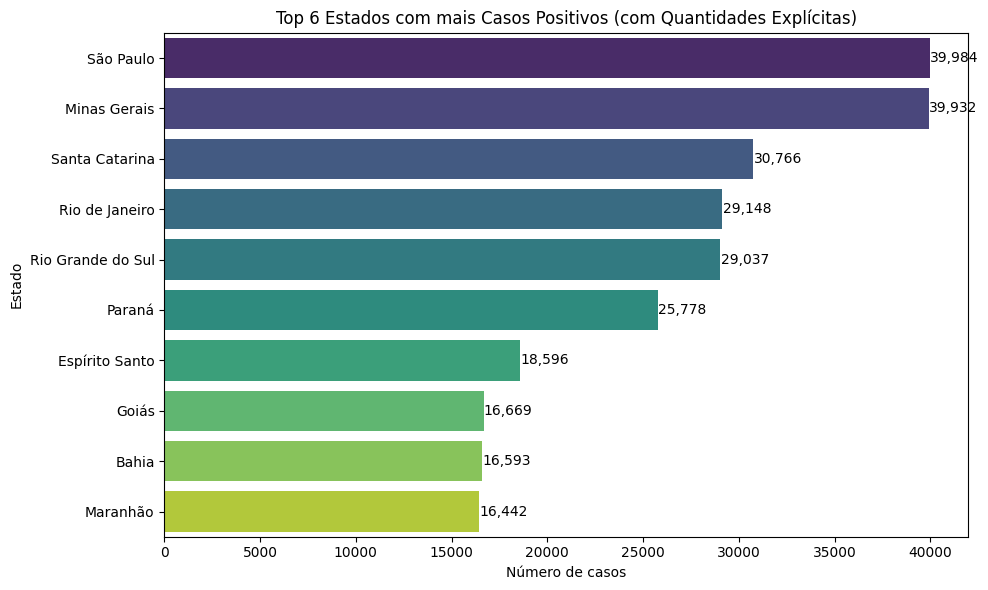

In [34]:



dict_uf = (
    df_filtro
    .filter(col("COD_VAR") == "UF")                     
    .select(col("COD_TIPO").alias("UF_code"), 
            col("DESCR_TIPO").alias("Estado"))
    .dropDuplicates(["UF_code"])                   
    .withColumn("UF_code", trim(col("UF_code").cast("string")))  
)


positivos_por_estado = (
    df_completo
    .filter(col("C001") == 1)                           
    .withColumn("UF", trim(col("UF").cast("string")))   
    .groupby("UF")
    .agg(count("*").alias("casos"))
)

positivos_com_nome = (
    positivos_por_estado
    .join(dict_uf, positivos_por_estado.UF == dict_uf.UF_code, how="left")
    .select(positivos_por_estado.UF.alias("UF_code"), "Estado", "casos")
    .orderBy(col("casos").desc())
    .limit(10)
)


pdf_top6 = positivos_com_nome.toPandas()
pdf_top6["Estado"] = pdf_top6["Estado"].fillna(pdf_top6["UF_code"])  # em caso de nome faltando


plt.figure(figsize=(10, 6)) 
ax = sns.barplot(x="casos", y="Estado", data=pdf_top6, palette="viridis") 


for p in ax.patches:

    width = p.get_width()

    y_pos = p.get_y() + p.get_height() / 2
    

    ax.text(width + 10,  
            y_pos, 
            '{:,.0f}'.format(width), 
            va='center')

plt.title("Top 6 Estados com mais Casos Positivos (com Quantidades Explícitas)")
plt.xlabel("Número de casos") 
plt.ylabel("Estado")         
plt.tight_layout()
plt.show()

### 2 - Positivos por área (Urbano/Rural)

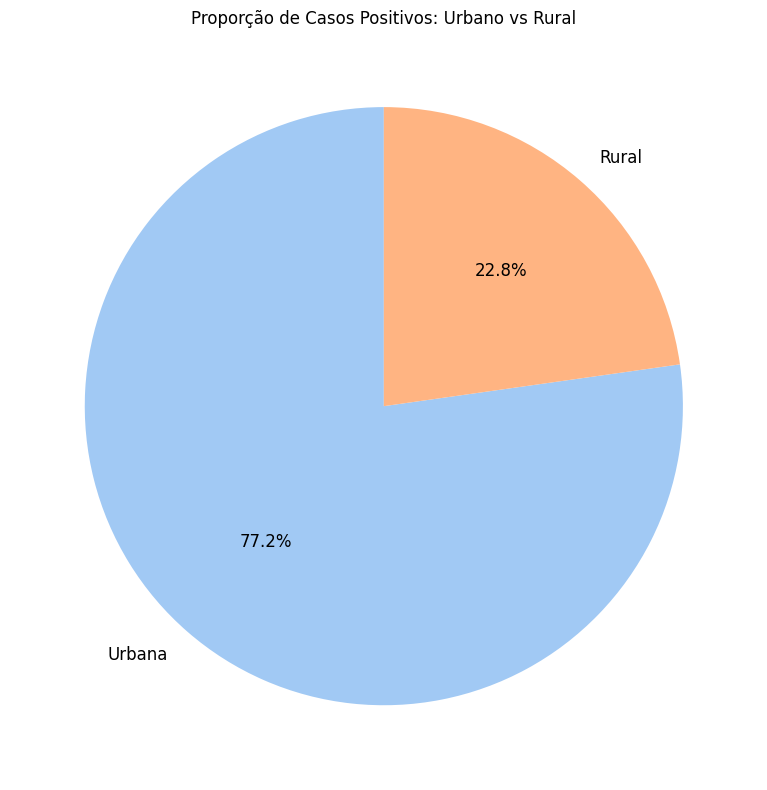

In [35]:


dict_v1022 = (
    df_filtro
    .filter(col("COD_VAR") == "V1022")
    .select(col("COD_TIPO").cast("int").alias("V1022_code"), col("DESCR_TIPO").alias("Area"))
    .dropDuplicates(["V1022_code"])
)


positivos_area = (
    df_completo
    .filter(col("C001") == 1)
    .groupby("V1022")
    .agg(count("*").alias("casos"))
)


positivos_area_desc = (
    positivos_area
    .join(dict_v1022, positivos_area.V1022 == dict_v1022.V1022_code, how="left")
    .select("Area", "casos")
    .orderBy(col("casos").desc())
)

pdf_area = positivos_area_desc.toPandas() 

plt.figure(figsize=(8, 8))
pdf_area.set_index("Area")['casos'].plot.pie(
    autopct="%1.1f%%",  
    startangle=90,      
    legend=False,
    fontsize=12,
    colors=sns.color_palette("pastel") 
)

plt.title("Proporção de Casos Positivos: Urbano vs Rural")
plt.ylabel("") 
plt.tight_layout()
plt.show()

### 3 - Faixas etárias

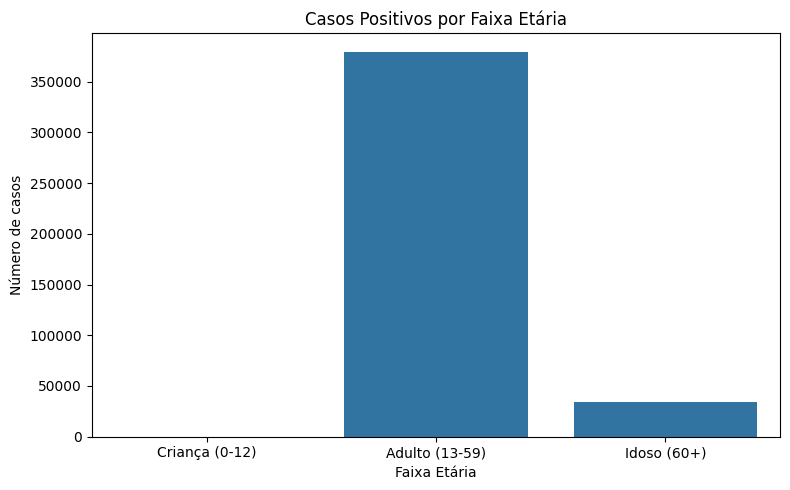

In [36]:

df_faixa = df_completo.withColumn(
    "faixa",
    when(col("A002") <= 12, "Criança (0-12)")
    .when((col("A002") > 12) & (col("A002") < 60), "Adulto (13-59)")
    .otherwise("Idoso (60+)")
)

positivos_idade = (
    df_faixa.filter(col("C001") == 1)
    .groupby("faixa")
    .agg(count("*").alias("casos"))
)

pdf_idade = positivos_idade.toPandas()

ordenacao_faixa = ["Criança (0-12)", "Adulto (13-59)", "Idoso (60+)"]
pdf_idade["faixa"] = pd.Categorical(pdf_idade["faixa"], categories=ordenacao_faixa, ordered=True)
pdf_idade = pdf_idade.sort_values("faixa")

plt.figure(figsize=(8,5))
sns.barplot(x="faixa", y="casos", data=pdf_idade)
plt.title("Casos Positivos por Faixa Etária")
plt.ylabel("Número de casos")
plt.xlabel("Faixa Etária")
plt.tight_layout()
plt.show()

### 4 - Homens vs Mulheres Infectados

<Figure size 800x800 with 0 Axes>

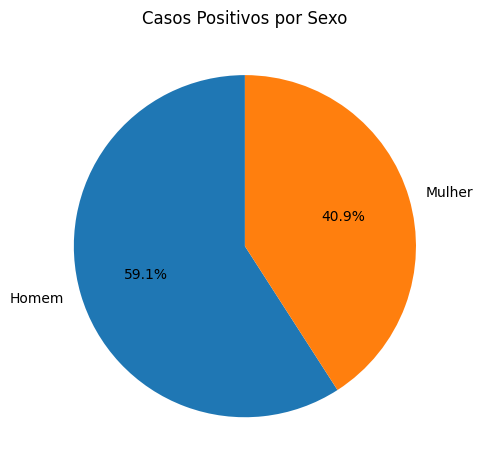

In [37]:

dict_a003 = (
    df_filtro
    .filter(col("COD_VAR") == "A003")
    .select(col("COD_TIPO").cast("int").alias("A003_code"), col("DESCR_TIPO").alias("Sexo"))
    .dropDuplicates(["A003_code"])
)


sexo_positivos = (
    df_completo.filter(col("C001") == 1)
    .groupby("A003")
    .agg(count("*").alias("casos"))
)


sexo_positivos_desc = (
    sexo_positivos
    .join(dict_a003, sexo_positivos.A003 == dict_a003.A003_code, how="left")
    .select("Sexo", "casos")
)


pdf_sexo = sexo_positivos_desc.toPandas()
plt.figure(figsize=(8, 8))
pdf_sexo.set_index("Sexo").plot.pie(y="casos", autopct="%1.1f%%", legend=False, startangle=90)
plt.title("Casos Positivos por Sexo")
plt.ylabel("")
plt.tight_layout()
plt.show()


### 5 - Estudantes ?

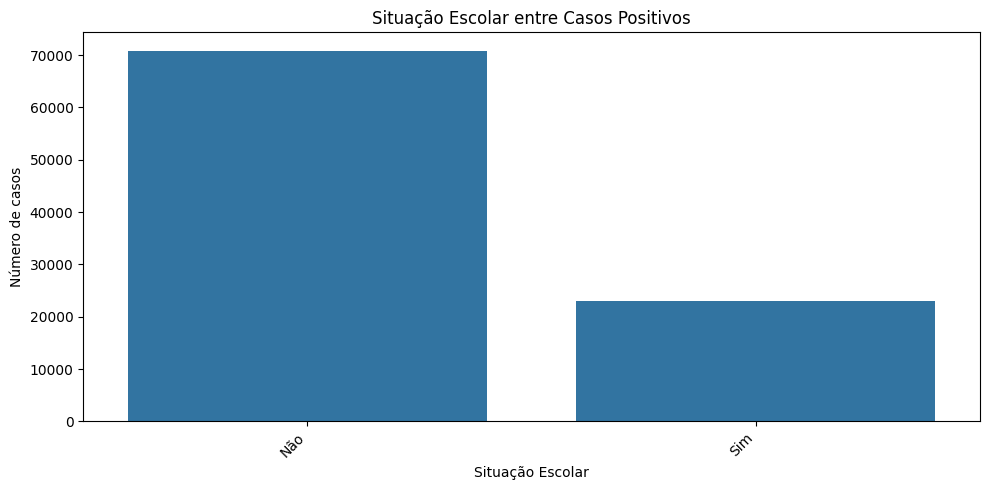

In [38]:

dict_a006 = (
    df_filtro
    .filter(col("COD_VAR") == "A006")
    .select(col("COD_TIPO").cast("int").alias("A006_code"), col("DESCR_TIPO").alias("Situacao_Escolar"))
    .dropDuplicates(["A006_code"])
    .filter(col("A006_code").isNotNull()) 
)


ocupacao = (
    df_completo
    .filter(col("C001") == 1)
    .filter(col("A006").isNotNull())
    .groupby("A006")
    .agg(count("*").alias("casos"))
)

ocupacao_desc = (
    ocupacao
    .join(dict_a006, ocupacao.A006 == dict_a006.A006_code, how="left")
    .select("Situacao_Escolar", "casos")
    .orderBy(col("casos").desc())
)


pdf_ocupacao = ocupacao_desc.toPandas()
plt.figure(figsize=(10,5))
sns.barplot(x="Situacao_Escolar", y="casos", data=pdf_ocupacao)
plt.title("Situação Escolar entre Casos Positivos")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Número de casos")
plt.xlabel("Situação Escolar")
plt.tight_layout()
plt.show()


### 6 - Casos por tipo de Trabalho (anteriormente "Profissão")

C:\Users\Igor\AppData\Local\Temp\ipykernel_20228\448815399.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="casos", y="Tipo_Trabalho", data=pdf_profissao_desc, palette="Spectral")


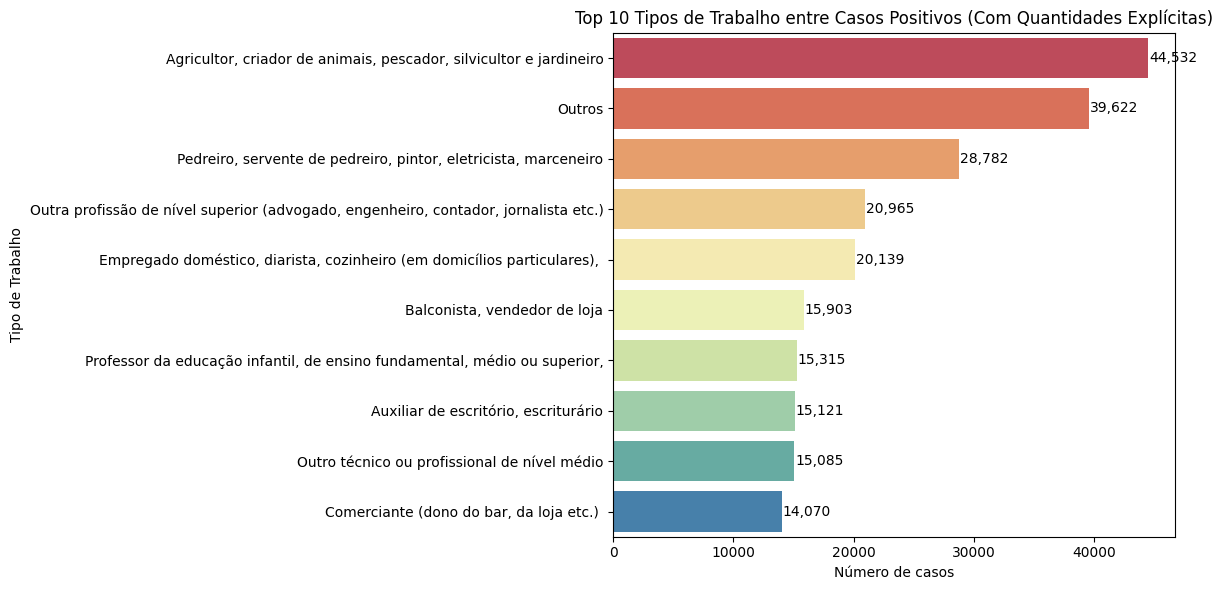

In [40]:

dict_c007c = (
    df_filtro
    .filter(col("COD_VAR") == "C007C")
    .select(col("COD_TIPO").cast("int").alias("C007C_code"), col("DESCR_TIPO").alias("Tipo_Trabalho"))
    .dropDuplicates(["C007C_code"])
    .filter(col("C007C_code").isNotNull())
)


profissao = (
    df_completo
    .filter(col("C001") == 1) 
    .filter(col("C007C").isNotNull()) 
    .groupby("C007C")
    .agg(count("*").alias("casos"))
)


profissao_desc = (
    profissao
    .join(dict_c007c, profissao.C007C == dict_c007c.C007C_code, how="left")
    .select("Tipo_Trabalho", "casos")
    .orderBy(col("casos").desc())
    .limit(10) 
)

pdf_profissao_desc = profissao_desc.toPandas()


plt.figure(figsize=(12, 6))
ax = sns.barplot(x="casos", y="Tipo_Trabalho", data=pdf_profissao_desc, palette="Spectral") 
plt.title("Top 10 Tipos de Trabalho entre Casos Positivos (Com Quantidades Explícitas)")
plt.xlabel("Número de casos")
plt.ylabel("Tipo de Trabalho")


for p in ax.patches:

    width = p.get_width()

    y_pos = p.get_y() + p.get_height() / 2
    

    ax.text(width + 50,  
            y_pos, 
            f'{int(width):,d}', 
            va='center')

plt.tight_layout()
plt.show()

### 7 -sintomas mais apresentados ?

C:\Users\Igor\AppData\Local\Temp\ipykernel_5280\4088359424.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Sintoma", y="Total", data=pdf_sintomas, palette="tab10")


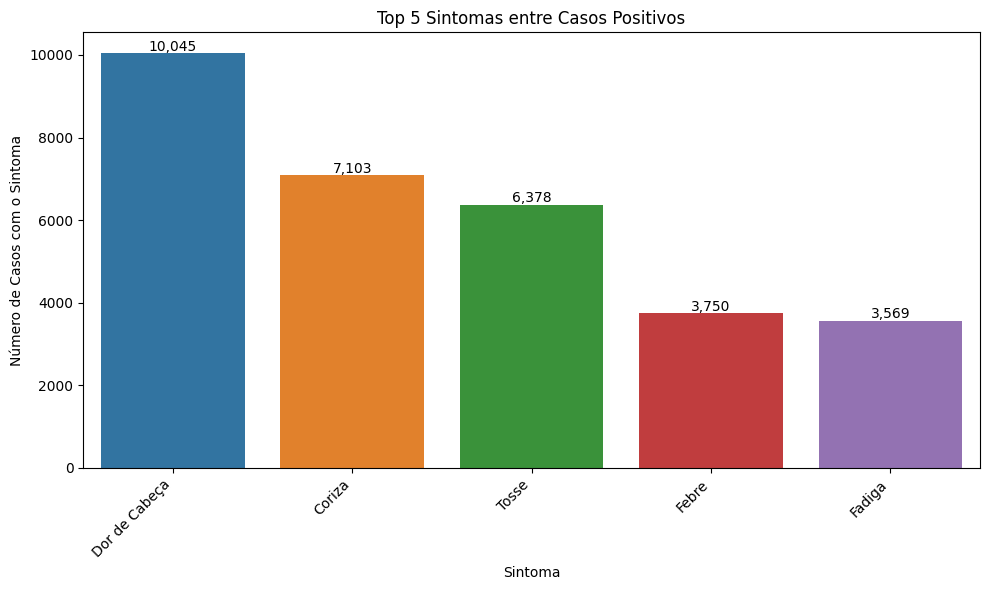

In [ ]:
sintomas_cols_originais = ["B0015", "B0011", "B0012", "B0014", "B0018", "B0019", "B00111"]


dict_sintomas = {
    "B0015": "Dor de Cabeça",
    "B0011": "Febre",
    "B0012": "Tosse",
    "B0014": "Dificuldade de Respirar",
    "B0018": "Coriza",
    "B0019": "Fadiga",
    "B00111": "Perda de Olfato/Paladar"
}


sintomas_agg = df_completo.filter(col("C001") == 1)

sintomas_sum = {}
for s in sintomas_cols_originais:

    soma = sintomas_agg.filter(col(s) == 1).agg(count("*").alias("total")).collect()[0]["total"]
    sintomas_sum[dict_sintomas[s]] = soma

pdf_sintomas = pd.DataFrame(list(sintomas_sum.items()), columns=["Sintoma", "Total"])
pdf_sintomas = pdf_sintomas.sort_values("Total", ascending=False).head(5)

plt.figure(figsize=(10, 6)) 
ax = sns.barplot(x="Sintoma", y="Total", data=pdf_sintomas, palette="tab10") 

for p in ax.patches:

    height = p.get_height()

    x_pos = p.get_x() + p.get_width() / 2
    

    ax.text(x_pos, 
            height + 50, 
            f'{int(height):,d}', 
            ha='center')

plt.title("Top 5 Sintomas entre Casos Positivos") 
plt.ylabel("Número de Casos com o Sintoma")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### 8 - Assintomáticos positivos?

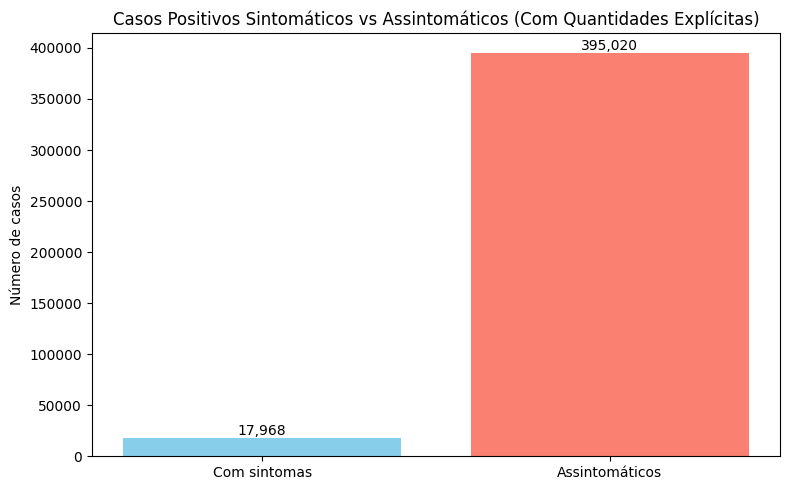

In [ ]:
df_sint = df_completo.withColumn(
    "tem_sintoma",
    when(
        (col("B0015") == 1) | 
        (col("B0011") == 1) | 
        (col("B0012") == 1) | 
        (col("B0014") == 1) | 
        (col("B0018") == 1) | 
        (col("B0019") == 1) | 
        (col("B00111") == 1), 
        lit(1)
    ).otherwise(lit(0))
)


com_sintomas = df_sint.filter((col("C001") == 1) & (col("tem_sintoma") == 1)).count()
sem_sintomas = df_sint.filter((col("C001") == 1) & (col("tem_sintoma") == 0)).count()


labels = ["Com sintomas", "Assintomáticos"]
sizes = [com_sintomas, sem_sintomas]
colors = ['skyblue', 'salmon']

plt.figure(figsize=(8, 5))
ax = plt.bar(labels, sizes, color=colors)
plt.title("Casos Positivos Sintomáticos vs Assintomáticos (Com Quantidades Explícitas)")
plt.ylabel("Número de casos")


for rect in ax:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2., height,
            f'{int(height):,d}', 
            ha='center', va='bottom')

plt.tight_layout()
plt.show()


### 9 Pessoas que Distanciamento Social para pessoas com SINTOMÁTICOS

C:\Users\Igor\AppData\Local\Temp\ipykernel_16372\1129758363.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax_A1 = sns.barplot(x="casos", y="Distanciamento", data=pdf_A1, palette="cividis")
C:\Users\Igor\AppData\Local\Temp\ipykernel_16372\1129758363.py:53: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


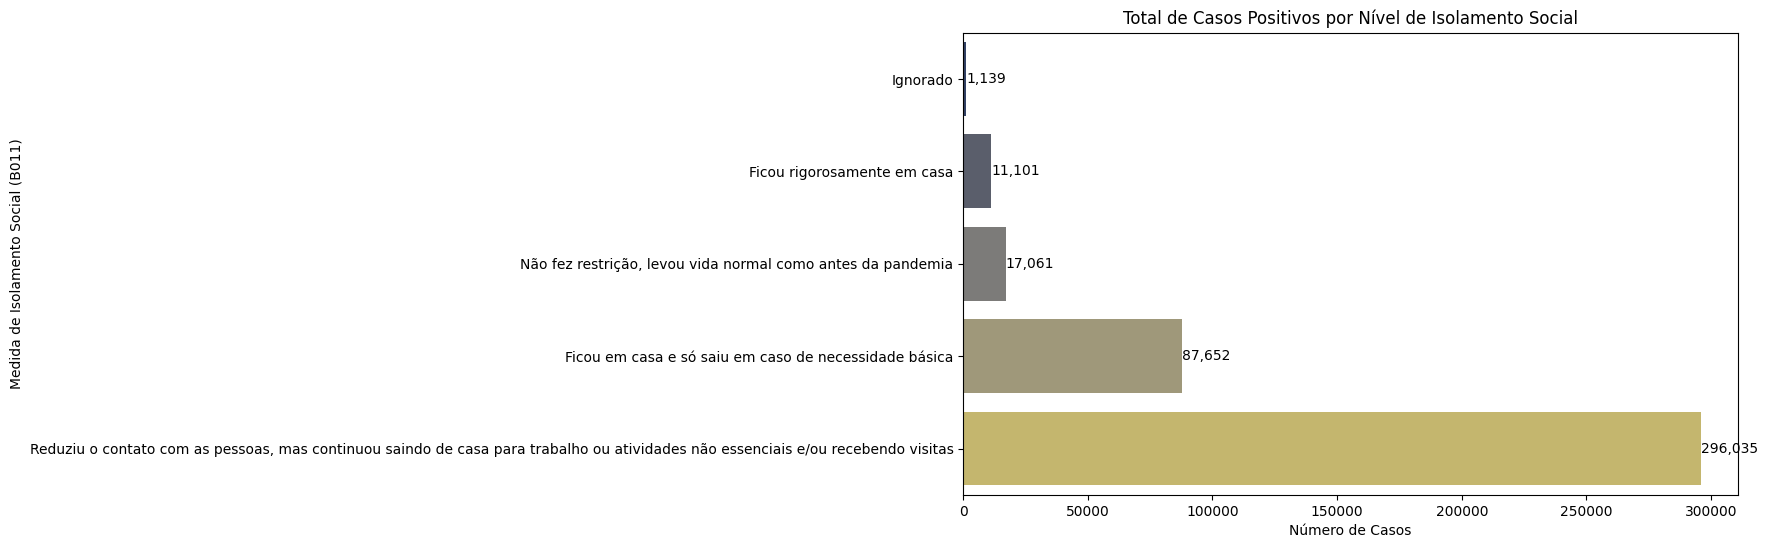

In [ ]:

dict_b011 = (
    df_filtro
    .filter(col("COD_VAR") == "B011")
    .select(col("COD_TIPO").cast("int").alias("B011_code"), col("DESCR_TIPO").alias("Distanciamento"))
    .dropDuplicates(["B011_code"])
    .filter(col("B011_code").isNotNull())
)

df_sint = df_completo.withColumn(
    "tem_sintoma",
    when(
        (col("B0015") == 1) | 
        (col("B0011") == 1) | 
        (col("B0012") == 1) | 
        (col("B0014") == 1) | 
        (col("B0018") == 1) | 
        (col("B0019") == 1) | 
        (col("B00111") == 1), 
        lit(1)
    ).otherwise(lit(0))
)


infected_by_isolation = (
    df_sint.filter(col("C001") == 1)
    .groupby("B011")
    .agg(count("*").alias("casos"))
)


infected_by_isolation_desc = (
    infected_by_isolation
    .join(dict_b011, infected_by_isolation.B011 == dict_b011.B011_code, how="left")
    .select("Distanciamento", "casos")
    .orderBy(col("casos").desc())
)
pdf_A1 = infected_by_isolation_desc.toPandas()
pdf_A1 = pdf_A1.sort_values(by="casos", ascending=True) # Ordena para o gráfico horizontal


plt.figure(figsize=(10, 6))
ax_A1 = sns.barplot(x="casos", y="Distanciamento", data=pdf_A1, palette="cividis") 


for p in ax_A1.patches:
    width = p.get_width()
    y_pos = p.get_y() + p.get_height() / 2
    ax_A1.text(width + 50, y_pos, f'{int(width):,d}', va='center')

plt.title("Total de Casos Positivos por Nível de Isolamento Social")
plt.xlabel("Número de Casos")
plt.ylabel("Medida de Isolamento Social (B011)")
plt.tight_layout()
plt.show()

### 9 Pessoas que Distanciamento Social para pessoas com ASSINTOMÁTICOS

C:\Users\Igor\AppData\Local\Temp\ipykernel_16372\4078460241.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax_A2 = sns.barplot(x="casos", y="Distanciamento", data=pdf_A2, palette="magma")
C:\Users\Igor\AppData\Local\Temp\ipykernel_16372\4078460241.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


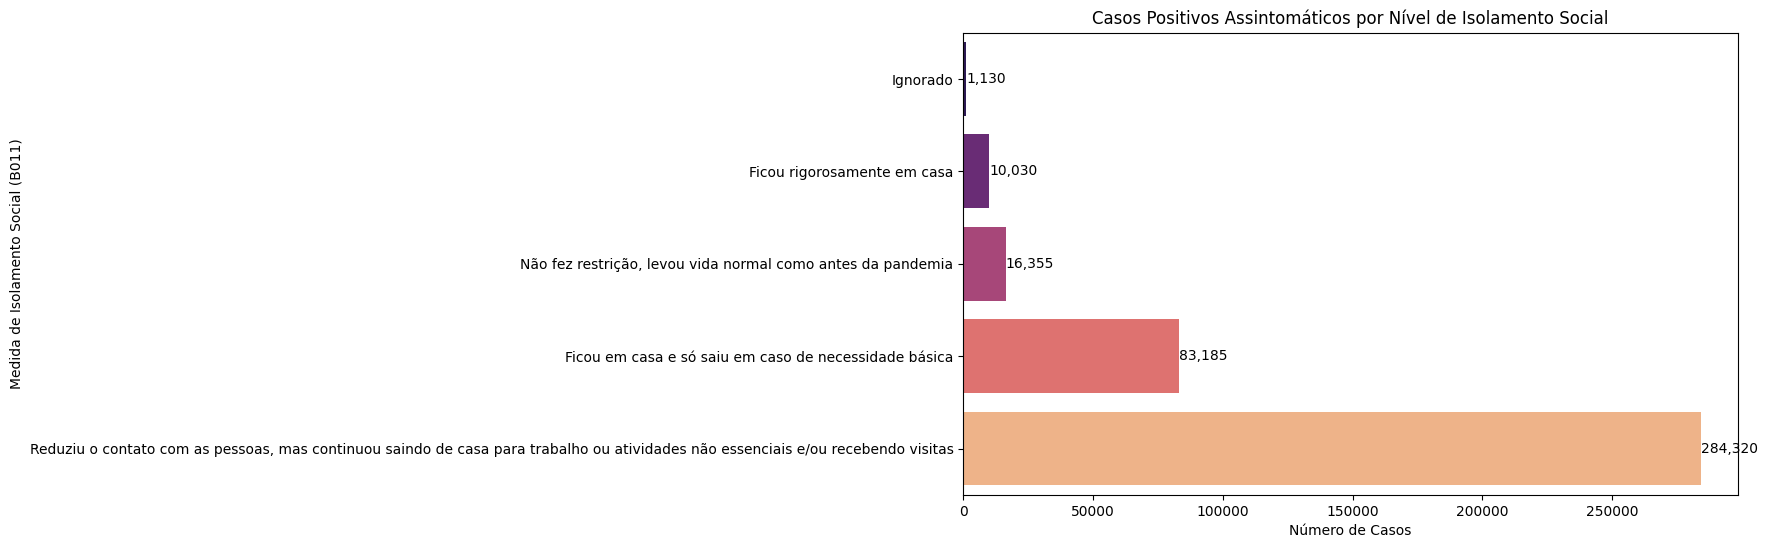

In [ ]:
asymptomatic_by_isolation = (
    df_sint.filter((col("C001") == 1) & (col("tem_sintoma") == 0)) # <--- Error occurs here
    .groupby("B011")
    .agg(count("*").alias("casos"))
)

# 4. Join e Conversão para Pandas
asymptomatic_by_isolation_desc = (
    asymptomatic_by_isolation
    .join(dict_b011, asymptomatic_by_isolation.B011 == dict_b011.B011_code, how="left")
    .select("Distanciamento", "casos")
    .orderBy(col("casos").desc())
)
pdf_A2 = asymptomatic_by_isolation_desc.toPandas()
pdf_A2 = pdf_A2.sort_values(by="casos", ascending=True) # Ordena para o gráfico horizontal


plt.figure(figsize=(10, 6))
ax_A2 = sns.barplot(x="casos", y="Distanciamento", data=pdf_A2, palette="magma") 


for p in ax_A2.patches:
    width = p.get_width()
    y_pos = p.get_y() + p.get_height() / 2
    ax_A2.text(width + 50, y_pos, f'{int(width):,d}', va='center')

plt.title("Casos Positivos Assintomáticos por Nível de Isolamento Social")
plt.xlabel("Número de Casos")
plt.ylabel("Medida de Isolamento Social (B011)")
plt.tight_layout()
plt.show()

### 10 Casos Positivos por Situação de Trabalho

C:\Users\Igor\AppData\Local\Temp\ipykernel_16372\1733820439.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Situação_Trabalho", y="casos", data=pdf_ocupacao_c001, palette="cubehelix")


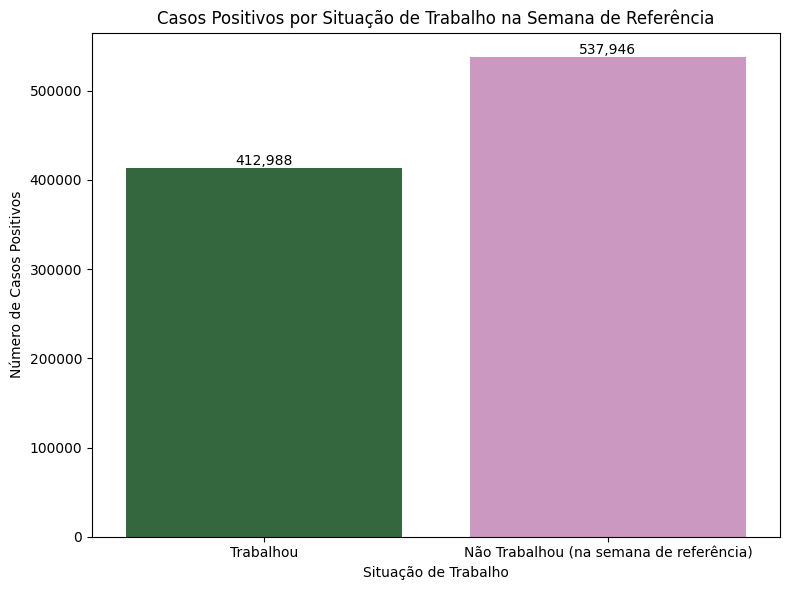

In [ ]:
dict_trabalho = {
    1: "Trabalhou",
    2: "Não Trabalhou (na semana de referência)"
}
map_trabalho_udf = udf(lambda x: dict_trabalho.get(x, "Não Aplicável"), StringType())


ocupacao_positivos = (
    df_renamed

    .filter(col("C001") != 3) 

    .filter(col("TRAB_SP_TRABALHOU").isin([1, 2])) 

    .groupby("TRAB_SP_TRABALHOU") 
    .agg(count("*").alias("casos"))
)

ocupacao_positivos_desc = (
    ocupacao_positivos

    .withColumn("Situação_Trabalho", map_trabalho_udf(col("TRAB_SP_TRABALHOU")))
    .select("Situação_Trabalho", "casos")
)


pdf_ocupacao_c001 = ocupacao_positivos_desc.toPandas()


plt.figure(figsize=(8, 6))
ax = sns.barplot(x="Situação_Trabalho", y="casos", data=pdf_ocupacao_c001, palette="cubehelix")
plt.title("Casos Positivos por Situação de Trabalho na Semana de Referência")
plt.ylabel("Número de Casos Positivos")
plt.xlabel("Situação de Trabalho")


for p in ax.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 50,
             f'{int(height):,d}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 11 - RESULTADOS DE TESTE (Complemento Clínico)

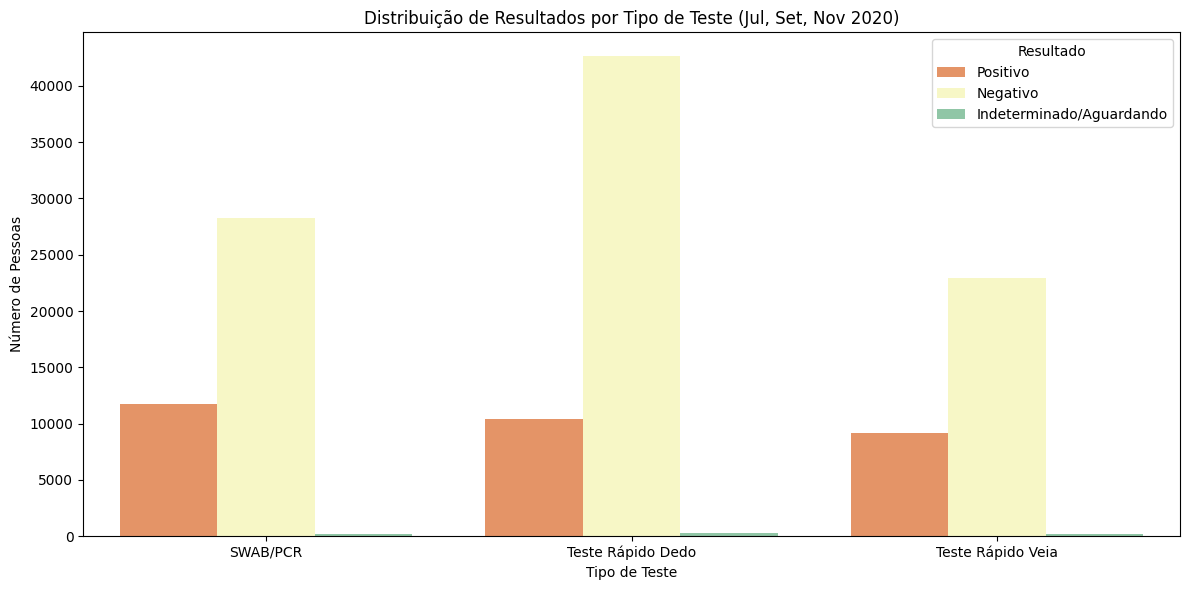

In [ ]:
dict_resultados = {
    1: "Positivo",
    2: "Negativo",
    3: "Indeterminado/Aguardando"
}

map_resultado_udf = udf(lambda x: dict_resultados.get(x, "Não Aplicável"), StringType())

df_swab = df_renamed.filter(col("TESTE_SWAB").isin([1, 2, 3])).select(col("TESTE_SWAB").alias("Resultado_Teste"), lit("SWAB/PCR").alias("Tipo_Teste"))
df_sangue_dedo = df_renamed.filter(col("TESTE_SANGUE_DEDO").isin([1, 2, 3])).select(col("TESTE_SANGUE_DEDO").alias("Resultado_Teste"), lit("Teste Rápido Dedo").alias("Tipo_Teste"))
df_sangue_veia = df_renamed.filter(col("TESTE_SANGUE_VEIA").isin([1, 2, 3])).select(col("TESTE_SANGUE_VEIA").alias("Resultado_Teste"), lit("Teste Rápido Veia").alias("Tipo_Teste"))

df_testes_unificado = df_swab.union(df_sangue_dedo).union(df_sangue_veia)

df_testes_agg = (
    df_testes_unificado
    .withColumn("Resultado_Desc", map_resultado_udf(col("Resultado_Teste")))
    .groupby("Tipo_Teste", "Resultado_Desc")
    .agg(count("*").alias("Total"))
    .orderBy(col("Tipo_Teste"), col("Total").desc())
)


pdf_testes = df_testes_agg.toPandas()


plt.figure(figsize=(12, 6))
order = list(dict_resultados.values())
sns.barplot(x="Tipo_Teste", y="Total", hue="Resultado_Desc", data=pdf_testes, palette="Spectral", hue_order=order)
plt.title("Distribuição de Resultados por Tipo de Teste (Jul, Set, Nov 2020)")
plt.xlabel("Tipo de Teste")
plt.ylabel("Número de Pessoas")
plt.legend(title="Resultado")
plt.tight_layout()
plt.show()

